# 机器学习工程师纳米学位
## 深度学习
## 项目：搭建一个数字识别项目

在此文件中，我们提供给你了一个模板，以便于你根据项目的要求一步步实现要求的功能，进而完成整个项目。如果你认为需要导入另外的一些代码，请确保你正确导入了他们，并且包含在你的提交文件中。以**'练习'**开始的标题表示接下来你将开始实现你的项目。注意有一些练习是可选的，并且用**'可选'**标记出来了。

在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以'练习'开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**注意：** Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

## 连接 mnist 的字符来合成数据

你可以通过连接[MNIST](http://yann.lecun.com/exdb/mnist/)的字符来合成数据来训练这个模型。为了快速导入数据集，我们可以使用 [Keras Datasets](https://keras.io/datasets/#mnist-database-of-handwritten-digits) [中文文档](http://keras-cn.readthedocs.io/en/latest/other/datasets/#mnist)。

### 载入 mnist

In [1]:
from keras.datasets import mnist
import itertools

(X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()

n_train, n_test = X_raw.shape[0], X_raw_test.shape[0]

Using TensorFlow backend.


### 可视化 mnist

我们可以通过 matplotlib 来可视化我们的原始数据集。

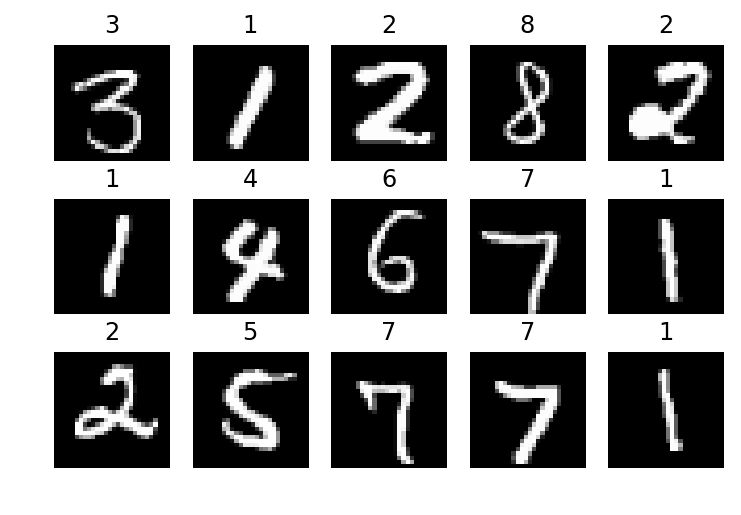

In [2]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

for i in range(15):
    plt.subplot(3, 5, i+1)
    index = random.randint(0, n_train-1)
    plt.title(str(y_raw[index]))
    plt.imshow(X_raw[index], cmap='gray')
    plt.axis('off')

### 练习：合成数据

你需要随机取随机张图片，然后将它们拼接成新的图片。

你需要设置20%的数据作为验证集，以保证模型没有过拟合。

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

n_class, n_len, width, height = 11, 5, 28, 28

def generate_dataset(X, y):
    X_len = X.shape[0]
    X_gen = np.zeros((X_len, height, width*n_len, 1), dtype=np.uint8)
    y_gen = [np.zeros((X_len, n_class), dtype=np.uint8) for i in range(n_len)]
    # TODO: 随机取1~5个数字，并拼接成新的图片
    for i in range(X_len):
        amount = random.randint(1, n_len)
        for j in range(amount):
            index = random.randint(0, X_len-1)
            digit_series_ind = y[index]
            y_gen[j][i][digit_series_ind] = 1            
            X_gen[i][:, width*j:width*(j+1)] = X[index].reshape((height, width, 1))
        for j in range(amount, n_len):
            y_gen[j][i][10] = 1
    y_gen = np.array(y_gen)
    return X_gen, y_gen

X_raw_train, X_raw_valid, y_raw_train, y_raw_valid = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

X_train, y_train = generate_dataset(X_raw_train, y_raw_train)
X_valid, y_valid = generate_dataset(X_raw_valid, y_raw_valid)
X_test, y_test = generate_dataset(X_raw_test, y_raw_test)

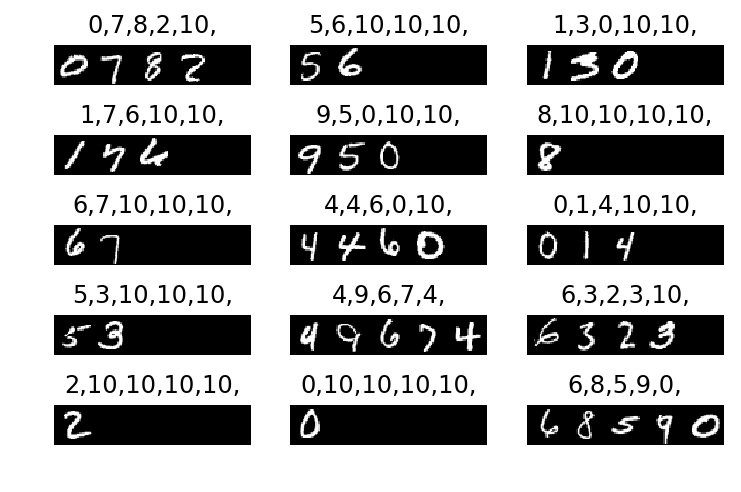

In [4]:
# 显示生成的图片
for i in range(15):
    plt.subplot(5, 3, i+1)
    index = random.randint(0, n_test-1)
    title = ''
    for j in range(n_len):
        title += str(np.argmax(y_test[j][index])) + ','
    
    plt.title(title)
    plt.imshow(X_test[index][:,:,0], cmap='gray')
    plt.axis('off')

## 加工数据集

构建字符集，并定义转换函数

In [5]:
letters = [str(i) for i in range(10)]
letters.append("#")

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

## 构建 data generator

创建一个DataGenerator类，完成数据的batch的产生

In [6]:
from __future__ import absolute_import
from keras.utils import * 
import random

class DataGenerator():
    """
    """
    def __init__(self, data_source_x, data_source_y):
        self.data_source_x = data_source_x
        self.data_amount = data_source_y.shape[1]
        self.transform_data_y = np.ones([self.data_amount, n_len])
        self.label_length = np.zeros((self.data_amount, 1))
        for i in range(self.data_amount):
            str_num = ""
            curr_len = 0
            for j in range(5):
                ch = np.argmax(data_source_y[j][i])
                if ch == 10:
                    str_num += "#"
                    pass
                else:
                    curr_len += 1
                    str_num += str(ch)
            self.label_length[i] = curr_len
            self.transform_data_y[i] = text_to_labels(str_num)
        
        self.batch_size = 4800
        
    def next_sample(self):
        idx = random.randint(0, self.data_amount-1)
        return self.data_source_x[idx, :, :, 0], self.transform_data_y[idx], self.label_length[idx]
    
    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, height, width*n_len, 1])
            Y_data = np.ones([self.batch_size, n_len])
            input_length_curr = np.ones((self.batch_size, 1)) * (width*n_len // 4 - 2)
            label_length_curr = np.zeros((self.batch_size, 1))
        
            for i in range(self.batch_size):
                x, y, label_length = self.next_sample()
                X_data[i, :, :, 0] = x
                Y_data[i] = y
                label_length_curr[i] = label_length
            
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length_curr,
                'label_length': label_length_curr,
                    }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [7]:
# 构建训练集
train_data_generator = DataGenerator(X_train, y_train)
# 构建验证集
valid_data_generator = DataGenerator(X_valid, y_valid)

### 问题 1
_你是如何合成数据集的？为什么要分训练集，验证集和测试集？_

**回答：**


数据的表示本身是用矩阵来表示的灰度图，这里只是需要将矩阵拼接到一起即可。

分训练集验证集是为了找到最效果最好的模型，测试集为了度量模型的性能。

### 练习：设计并测试一个模型架构

设计并实现一个能够识别数字序列的深度学习模型。为了产生用于测试的合成数字序列，你可以进行如下的设置：比如，你可以限制一个数据序列最多五个数字，并在你的深度网络上使用五个分类器。同时，你有必要准备一个额外的“空白”的字符，以处理相对较短的数字序列。

在思考这个问题的时候有很多方面可以考虑：

- 你的模型可以基于深度神经网络或者是卷积神经网络。
- 你可以尝试是否在每个分类器间共享权值。
- 你还可以在深度神经网络中使用循环网络来替换其中的分类层，并且将数字序列里的数字一个一个地输出。

在使用 Keras 搭建模型的时候，你可以使用 [函数式模型 API](http://keras-cn.readthedocs.io/en/latest/models/model/) 的方式来搭建多输出模型。

In [8]:
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
from keras.layers import Input,Conv2D,MaxPooling2D,ZeroPadding2D, Activation, Dropout
from keras.layers import Flatten,BatchNormalization,Permute,TimeDistributed,Dense,Bidirectional,GRU
from keras.models import Model

import numpy as np
import os
from keras.models import load_model
from keras.layers import Reshape, Lambda
from keras.optimizers import SGD
from keras.layers.merge import add, concatenate

rnn_size  = 256
pool_size = 2
conv_filters = 32
kernel_size = (3, 3)
time_dense_size = 128
act = 'relu'
n_len = 5


input_layer = Input(shape=(height, width*n_len, 1),name='the_input')
inner = Permute((2, 1, 3),name='permute')(input_layer)
inner = Conv2D(conv_filters, kernel_size=kernel_size,activation='relu',padding='same',kernel_initializer='he_normal',name='conv1')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='pool1')(inner)
inner = Conv2D(conv_filters, kernel_size=kernel_size, activation='relu',padding='same',kernel_initializer='he_normal',name='conv2')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='pool2')(inner)

conv_shape = inner.get_shape()
conv_to_rnn_dims = (int(conv_shape[1]), int(conv_shape[2] * conv_shape[3]))
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, kernel_initializer='he_uniform', name='dense1')(inner)
inner = BatchNormalization()(inner)
# inner = Activation(act)(inner)
inner = Dropout(0.2)(inner)

# Two layers of bidirecitonal GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

inner = concatenate([gru_2, gru_2b])
inner = Dropout(0.25)(inner)

# transforms RNN output to character activations:
inner = Dense(n_class, kernel_initializer='he_normal',
              name='dense2')(inner)

y_pred = Activation('softmax', name='softmax')(inner)
Model(inputs=input_layer, outputs=y_pred).summary()

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

model = Model(inputs=[input_layer, labels, input_length, label_length], outputs=loss_out)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 28, 140, 1)   0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 140, 28, 1)   0           the_input[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 140, 28, 32)  320         permute[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 70, 14, 32)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Con

### 问题 2
_你为解决这个问题采取了什么技术？请详细介绍你使用的技术。_

**回答：** 


使用了 OCR 技术来识别不定长的文本内容。使用CNN+RNN+CTC 模型。

使用CNN来抽取图形特征，在图像识别上卷积操作类似于一个加权平均的过程，对于图像上的不同结构作用后抽到就可以作为特征，不同的卷积核又能得到不同的特征，如有的卷积核能提取到颜色信息，有的抽取曲线信息，有的得到明暗变化信息。卷积作用后就可以作为一种抽象特征来使用。

利用RNN产生多个输出。对于LSTM和GRU，首先LSTM叫长短时记忆网络，通过三个门遗忘门，输入门，输出门三个门来捕捉长依赖信息，GRU则是更新门和重置门两个门捕捉，相对来说较LSTM收敛更快，训练量更小，这里采用GRU主要是想着减少点计算量。毕竟是在CPU上训练的。

最后用CTC来对RNN的多个输出进行进一步的解码，在模型最后使用CTC计算loss的时候就能看出，输入时加上标签的长度信息，应用CTC技术本质上是在算切割多少分最好，训练时每次都会得到切割出多少个数字的概率分布。

### 可视化你的网络模型

参考链接：[可视化visualization](http://keras-cn.readthedocs.io/en/latest/other/visualization/)

可以是保存成 PNG 格式显示，也可以直接使用 SVG 格式。 SVG 是矢量图，它的优点是可以无限放大。

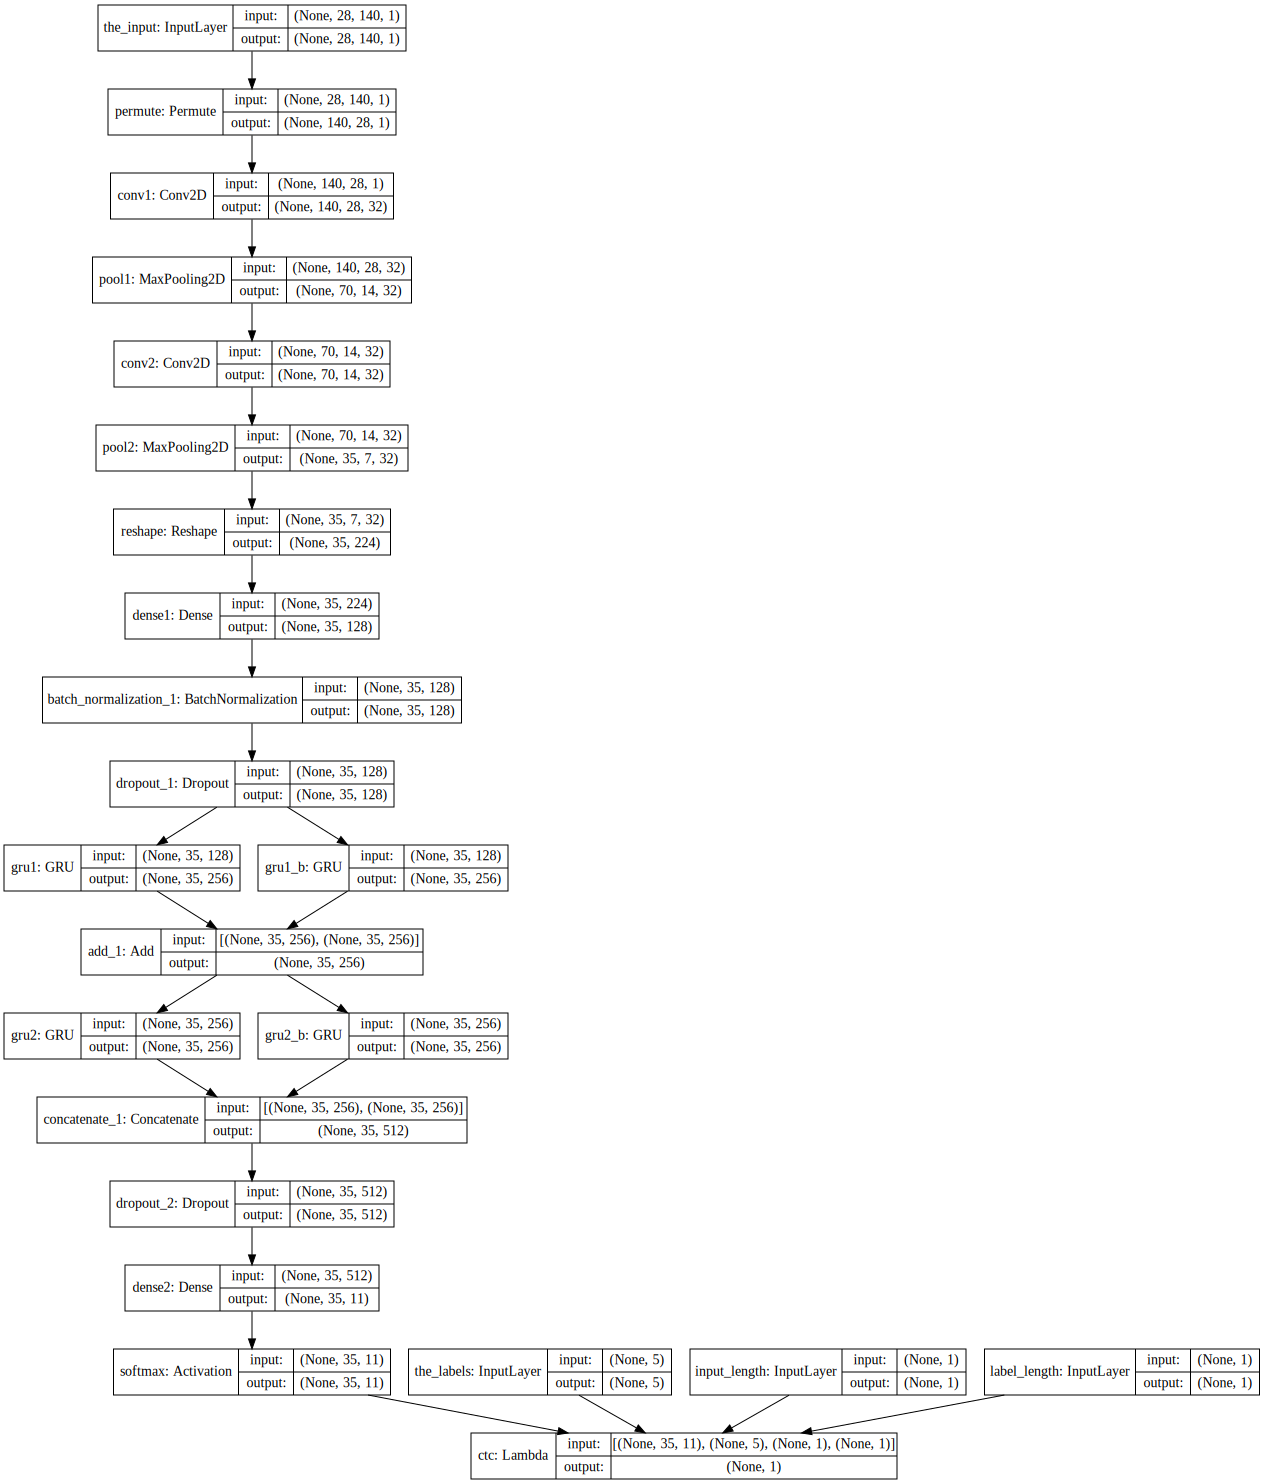

In [10]:
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import Image, SVG

# TODO: 可视化你的模型
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 问题 3
_你最终的模型架构是什么样的？（什么类型的模型，层数，大小, 如何连接等）_

**回答：**


模型总体结构如上，CNN+RNN+CTC的结构。

模型输入为（28， 140， 1）。

第一层为一个permute层，将图片转了个方向，输出（140， 28， 1）

第二层为 卷积层，输出通道数32个，输出（140, 28, 32）

第三层为池化层，输入（140, 28, 32），输出（70， 14， 32）

第四层，第五层重复第二层第三层。输出（35， 7， 32）

接着一个reshape层，将高和特征放在一个维度，输出（35， 244）

然后用Dense层降维到（35， 128）。

接着一个 BatchNormalization层规范化一下，输出还是（35， 128）

再接一个Dropout层防止过拟合。输出（35， 128）

再接两个双向的GRU层，最后输出（35， 512）

再接一个Dropout层防止过拟合。

再加一个Dense全连接层。输入（35， 512）， 输出（35， 11）

最后加入CTC，输入有四个，训练数据，训练数据标签，以及输入的长度和各个标签的内容文字长度。

总共1,423,851个训练参数。
__________________________________________________________________________________________________

### 练习：训练你的网络模型

训练你的模型时，需要设置训练集和验证集。

In [11]:
# TODO: 训练你的模型
# model.fit(X_train_old, y_train_old, batch_size=100, epochs=25)
history=model.fit_generator(generator=train_data_generator.next_batch(), 
                            steps_per_epoch = 10,#train_data_generator.data_amount, 
                            epochs=65,
                            validation_data=valid_data_generator.next_batch(),
                            validation_steps= 3,#valid_data_generator.data_amount
                           )

Epoch 1/65
10/10 [==============================] - 270s 27s/step - loss: 18.4491 - acc: 0.0000e+00 - val_loss: 20.9150 - val_acc: 0.0000e+00
Epoch 2/65
10/10 [==============================] - 268s 27s/step - loss: 8.8274 - acc: 0.0000e+00 - val_loss: 10.3977 - val_acc: 0.0000e+00
Epoch 3/65
10/10 [==============================] - 270s 27s/step - loss: 6.9874 - acc: 0.0000e+00 - val_loss: 7.4815 - val_acc: 0.0000e+00
Epoch 4/65
10/10 [==============================] - 269s 27s/step - loss: 5.1879 - acc: 0.0037 - val_loss: 4.9145 - val_acc: 0.0053
Epoch 5/65
10/10 [==============================] - 270s 27s/step - loss: 3.7380 - acc: 0.0416 - val_loss: 3.4708 - val_acc: 0.0660
Epoch 6/65
10/10 [==============================] - 273s 27s/step - loss: 2.6961 - acc: 0.1231 - val_loss: 2.3999 - val_acc: 0.1885
Epoch 7/65
10/10 [==============================] - 276s 28s/step - loss: 1.9961 - acc: 0.2387 - val_loss: 1.6940 - val_acc: 0.3326
Epoch 8/65
10/10 [==============================]

10/10 [==============================] - 276s 28s/step - loss: 0.0464 - acc: 0.9789 - val_loss: 0.0982 - val_acc: 0.9649
Epoch 63/65
10/10 [==============================] - 275s 27s/step - loss: 0.0464 - acc: 0.9787 - val_loss: 0.1106 - val_acc: 0.9581
Epoch 64/65
10/10 [==============================] - 272s 27s/step - loss: 0.0426 - acc: 0.9810 - val_loss: 0.0964 - val_acc: 0.9630
Epoch 65/65
10/10 [==============================] - 275s 28s/step - loss: 0.0425 - acc: 0.9810 - val_loss: 0.0931 - val_acc: 0.9642


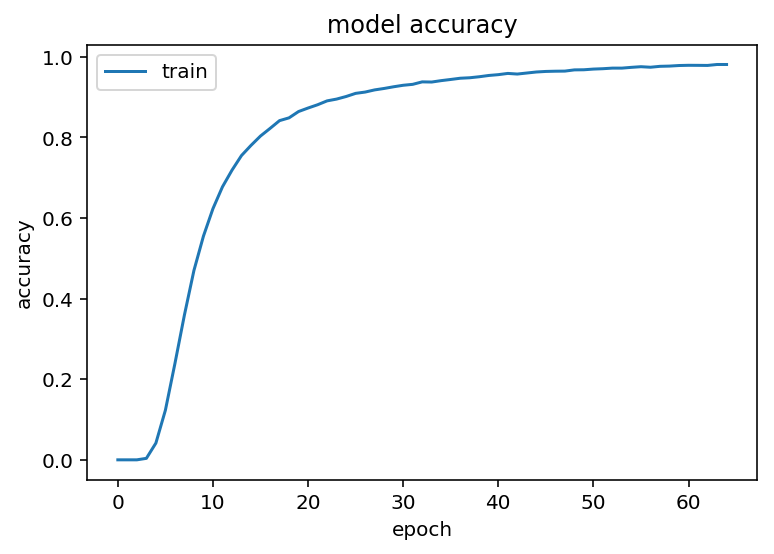

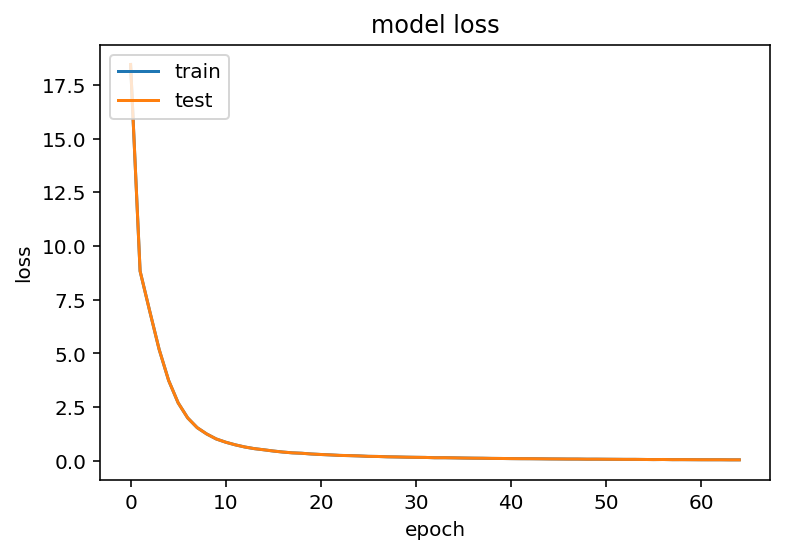

In [12]:
plt.plot()  
plt.plot(history.history['acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

### 练习：计算你的模型准确率

我们刚才得到了模型每个数字的准确率，现在让我们来计算整体准确率，按照完全预测正确数字序列的标准来计算。

比如 1,2,3,10,10 预测成了 1,2,10,10,10 算错，而不是算对了80%。

In [13]:

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                if letters[c] == '#':
                    continue
                outstr += letters[c]
        ret.append(outstr)
    return ret

def decode_data(y_data):
    outstr = ''
    for item in y_data:
        if item != 10:
            outstr += str(int(item))
    return outstr

def decode_data2(y_data):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        if np.argmax(y_data[i]) == 10:
            continue
        resultstr += str(np.argmax(y_data[i]))
    return resultstr
# print model.predict()
# def evaluate(model):
#     # TODO: 按照错一个就算错的规则计算准确率
    
    
# #     print "accuracy: %f" % (float(right_count)/X_test.shape[0])
# #     print wrong_count
# evaluate(model)

In [14]:
net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

model_out = Model(net_inp, net_out)
pred = model_out.predict(X_test, batch_size=512, verbose=1)

test_amount = 0
correct_amount = 0
for i in range(len(pred)):
    pred_text = decode_batch(pred[i:i+1])
    real_text = decode_data2([y_test[x][i] for x in range(n_len)])
    if pred_text[0] == real_text:
        correct_amount += 1
    test_amount += 1

print "test amount: %d, right answers: %d" % (test_amount, correct_amount)
print "accurrcy: %f" % (float(correct_amount)/test_amount)

10000/10000 [==============================] - 18s 2ms/step
test amount: 10000, right answers: 9702
accurrcy: 0.970200


### 问题 4

_你的模型准确率有多少？你觉得你的模型足以解决问题吗？_

**回答：**

正确率：97.02%

勉强能解决问题吧，后面尝试增加模型复杂度，优化训练参数来提升模型性能。好像单纯的CNN都能达到97%以上，模型还需要再复杂化一下来提高正确率。

### 预测值可视化

我们将模型的预测结果和真实值画出来，观察真实效果。

(-0.5, 139.5, 27.5, -0.5)

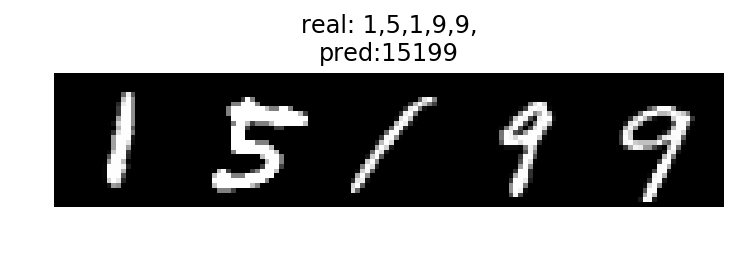

In [15]:
def get_result(result):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        resultstr += str(np.argmax(result[i])) + ','
    return resultstr

index = random.randint(0, n_test-1)

y_pred = model_out.predict(X_test[index:index+1])
# y_pred = model.predict(X_test[index].reshape(5, height, width, 1))

# plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), get_result(y_pred)))
plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), decode_batch(y_pred)[0]))
plt.imshow(X_test[index,:,:,0], cmap='gray')
plt.axis('off')

### 保存模型

模型达到满意的效果以后，我们需要保存模型，以便下次调用。

读取的方式也很简单：`model = load_model('model.h5')`

In [16]:
model_out.save('model.h5')

In [17]:
a = np.array([1, 3, 2])
print a[1:2]

[3]
